# RQ4: To what extent can Machine Learning/NLP models identify the sensemaking aspect of feedback?

## Part 5: Using DistilBERT To Identify Sensemaking and Impact vs the Rest

In part 5 of RQ4, we are going to use a deep learning algorithm called DistilBERT to train a model to differentiate between Sensemaking and Impact vs the Rest. This uncased DistilBERT model was provided by the Hugging Face AI community. It was customised here to serve the needs of the sensemaking classifications in this study. Reference: [Class Balancing](https://medium.com/@nikviz/bert-handling-class-imbalance-in-language-models-7fe9ccc62cb6)

This is a different implementation of DistilBERT by using the Keras training library `ktrain` that sits on top of the Tensorflow Classifer. This is because the data for the third scenario (Sensemaking and Impact vs the Rest) is not balanced. Therefore we are going to use the `ktrain` library to use class penalty weights. These weights penalise the majority class to prevent it from overwhelm the minority class.

We used `SMOTE` in Part 1 and Part 2 of this research question for the machine learning models as it can be used on feature extracted data such as TF-IDF and LIWC. However, DistilBERT has its own encoder that extracts the features from the data. Therefore it accepts natural text which cannot be processed by `SMOTE`. 

We will also used this method to train the DistilBERT model for the second scenario (Sensemaking 1 vs. Sensemaking 2) given in the Part 4 notebook for RQ4.

### 1. Loading the Initial Libraries and the Dataset

First, we need to load the initial set of libraries and the feedback data to be used in training the model.

In [1]:
# Importing the necessary libraries
import pandas as pd
import re
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Importing the data
data = pd.read_csv('/kaggle/input/feedback-data-analysis/stage2.csv')
data = data[['SentenceScoreRem', 'Rubric']]

# Checking the data
data.head()

,SentenceScoreRem,Rubric
0,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1
2,The team submitted the workbook 23 days after ...,Sensemaking 2
3,Risk assessment and report needs work as discu...,Sensemaking 1
4,"""Good effort, Please refer to detailed feedbac...",Agency 2&Agency 1


### 2. Cleaning the Text and Preparing the Data

We can define a function in the same way we defined it for the data in part 2. This function will clean the text by tokenizing it and removing the stop words.

In [3]:
# Defining a function to clean the sentencescorerem column
def clean_text(text):
    
    # Converting the characters of the text to lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    
    # Tokenizing the text
    tokens = nltk.word_tokenize(text)
    
    # Downloading the stop words from the NLTK corpus
    stopwords = nltk.corpus.stopwords.words('english')
    
    # Removing the stopwords from the text
    filtered_tokens = [token for token in tokens if token not in stopwords]
    
    # Joining the cleaned text
    clean_text = ' '.join(filtered_tokens)
    
    # Returning the cleaned text
    return clean_text

# Applying the clean text function to the data
data['text'] = data['SentenceScoreRem'].apply(clean_text)

# Splitting the preprocessed data into features and target variable
features = data['text']
target = data['Rubric']

# Checking the cleaned data
data[['text', 'Rubric']]

,text,Rubric
0,yuejing depth analysis required see link key c...,Sensemaking 1&Impact 1
1,team requested workbook better original mark,Impact 1
2,team submitted workbook days submission date kv,Sensemaking 2
3,risk assessment report needs work discussed tu...,Sensemaking 1
4,good effort please refer detailed feedback fil...,Agency 2&Agency 1
...,...,...
5754,q need use english communicate partiularly par...,Impact 1
5755,part b complicated needed explain rate change ...,Sensemaking 1
5756,q english exposition required,Impact 2
5757,made two errors finding determinant part b fin...,Sensemaking 1


For case 3, we need to define a function that checks whether the text contains a Sensemaking and Future Impact comment together and assigns a value of 1 for those rows and 0 otherwise. Hence, this will be our target variable for this case.

In [5]:
# Defining a function to check for the (Sensemaking and Impact)
def sensemaking_impact(rub):

    if 'Sensemaking' in rub and 'Impact' in rub:

        return 1

    else:

        return 0

# Applying the above label    
data['label'] = data['Rubric'].apply(lambda x : sensemaking_impact(x))

# Checking the new columns
data[['text', 'Rubric', 'label']]

,text,Rubric,label
0,yuejing depth analysis required see link key c...,Sensemaking 1&Impact 1,1
1,team requested workbook better original mark,Impact 1,0
2,team submitted workbook days submission date kv,Sensemaking 2,0
3,risk assessment report needs work discussed tu...,Sensemaking 1,0
4,good effort please refer detailed feedback fil...,Agency 2&Agency 1,0
...,...,...,...
5754,q need use english communicate partiularly par...,Impact 1,0
5755,part b complicated needed explain rate change ...,Sensemaking 1,0
5756,q english exposition required,Impact 2,0
5757,made two errors finding determinant part b fin...,Sensemaking 1,0


As shown in the above view, we have our target variable that contains two classes. In the next step, let us separately store the target variable and the feedback text.

In [6]:
# Storing the features and the target variable separately
features = data['text']
target = data['label']

Let us check the extent of imbalance in the target variable.

In [7]:
# Checking the class distribution of the target variable
data['label'].value_counts()

0    5255
1     504
Name: label, dtype: int64

As was the case with the data in part 2, there is a severe class imbalance in the data. It is likely that this imbalance will persist when we split the data into the training and testing data sets. We will come to that shortly. First, let us install and import the `ktrain` library to use the Keras module.

In [8]:
# Installing the ktrain library for Keras
pip install ktrain

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Importing the required libraries including the ktrain library
import ktrain
from sklearn.model_selection import train_test_split

### 3. Creating the Class Weights and Training the Model

Before creating the class weights, let us create the container for holding the class weights. We can also use the `train_test_split` module from the `sklearn` library to split the data into training and testing. This time, the split will be set at 90-10 just to ensure that the training process has as much data as possible.

In [10]:
# Creating the class container
classes =  list(set(data.label))

# Splitting the data into the training and validation data sets
X_train, X_test, y_train, y_test = train_test_split(data.text, data.label, test_size=0.01, random_state=42)

We will use the training and test data to build the classifier with the `text` module from the `ktrain` library.

In [11]:
# Importing the text module from the ktrain library
from ktrain import text

# Preprocessing the data
trn, val, preproc = text.texts_from_array(x_train=X_train.values, y_train=y_train.values,
                                          x_test=X_test.values, y_test=y_test.values,
                                                                   class_names=classes,
                                                                   val_pct=0.1, 
                                                                   max_features=30000, 
                                                                   maxlen=350,
                                                                   preprocess_mode='distilbert',
                                                                   ngram_range=1)

# Building the classifier with the train and test data
model = text.text_classifier('distilbert', train_data=trn, preproc=preproc)

preprocessing train...
language: en
train sequence lengths:
	mean : 11
	95percentile : 27
	99percentile : 49


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 23
	99percentile : 49


task: text classification
Is Multi-Label? False
maxlen is 350
done.


To handle the class imbalance, we can start building the weights with the help of the `utils` module of the `sklearn` library. Once the class weights have been created, we can use them and the trained classifer to start training the model with the `ktrain`'s model learner.

We will also autofit this learner so that it calculates the loss function and finds the best learning rate for the model with the class weights.

[0.54827852 5.67828685]
{0: 0.5482785150990576, 1: 5.6782868525896415}
simulating training for different learning rates... this may take a few moments...
Epoch 1/5
950/950 [==============================] - 161s 155ms/step - loss: 0.4483 - accuracy: 0.8782
Epoch 2/5
950/950 [==============================] - 149s 156ms/step - loss: 0.2228 - accuracy: 0.9141
Epoch 3/5
950/950 [==============================] - 149s 157ms/step - loss: 0.3354 - accuracy: 0.9094
Epoch 4/5
950/950 [==============================] - 58s 61ms/step - loss: 1.2303 - accuracy: 0.8836


done.
Visually inspect loss plot and select learning rate associated with falling loss


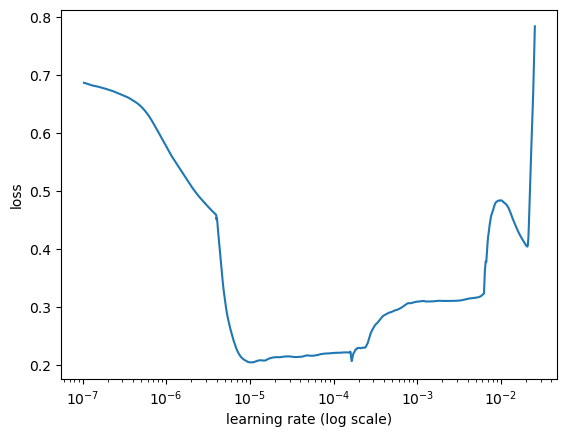



begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/3
951/951 [==============================] - 161s 160ms/step - loss: 0.4389 - accuracy: 0.7755 - val_loss: 0.2748 - val_accuracy: 0.8621
Epoch 2/3
951/951 [==============================] - 149s 156ms/step - loss: 0.2642 - accuracy: 0.8856 - val_loss: 0.2905 - val_accuracy: 0.8276
Epoch 3/3
951/951 [==============================] - 150s 156ms/step - loss: 0.1759 - accuracy: 0.9290 - val_loss: 0.1564 - val_accuracy: 0.9483


In [19]:
# Importing the required library to create the class weights and handle the class imbalance
#from sklearn.utils import class_weight
import sklearn.utils as ut

# Creating the class weights
class_weights = ut.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )

# Printing the class weights
print(class_weights)

# Creating an empty dictionary to store the class weights and their indexes
weights={}

# Looping through the class weights and their corresponding indexes and storing them in the dictionary
for index, weight in enumerate(class_weights) :
    weights[index]=weight

# Printing the organised class weights    
print(weights)

# Applying the weights to the learner with the classifier
learner =  ktrain.get_learner(model, train_data=trn, val_data=val,batch_size=6)

# Finding the optimum learning rate and plotting the loss function
learner.lr_find(show_plot=True,max_epochs=5)

# Using the optimum learning rate to fit the model for 5 epochs
learner.autofit(2e-5, 3,class_weight = weights)

As shown in the loss plot and Keras callbacks, the model was trained with the triangular learning rate policy and a maximum learning or $2e^5$ and the final accuracy that was achieved with the fifth epoch is 93%. We can validate the model to view its precision, recall and F1-score by using the `validate` function

In [20]:
# Test the result (You can use this to compare the results, before and after applying weights)
learner.validate()

2/2 [==============================] - 3s 162ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        56
           1       0.40      1.00      0.57         2

    accuracy                           0.95        58
   macro avg       0.70      0.97      0.77        58
weighted avg       0.98      0.95      0.96        58



array([[53,  3],
       [ 0,  2]])

The model has achieved an exceptional precision and recall of 98% and 95% respectively. Of all three variations of the DistilBERT model, this third model has outperformed the four machine learning models in terms of identifying Sensemaking and Impact comments vs. the rest.

In [21]:
# Saving the Model
# Optional Step to demonstrate how to save the model
learner.save_model('./SavedModels/DetectSensemakingFutureImpact')
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('./SavedModels/DetectSensemakingFutureImpact')